In [1]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
%matplotlib widget

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight

        def observation_update(self, observation):
            for p in self.particles:
                p.observation_update(observation)

    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + \
            ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds={"nn": 0.19, "no": 0.001, "on": 0.13, "oo": 0.2}):
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)

    def motion_update(self, nu, omega, time):
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)

    def observation_update(self, observation):
        print(observation)

    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval

        self.prev_nu = 0.0
        self.prev_omega = 0.0

    def decision(self, observation=None):
        self.estimator.motion_update(
            self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega

    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

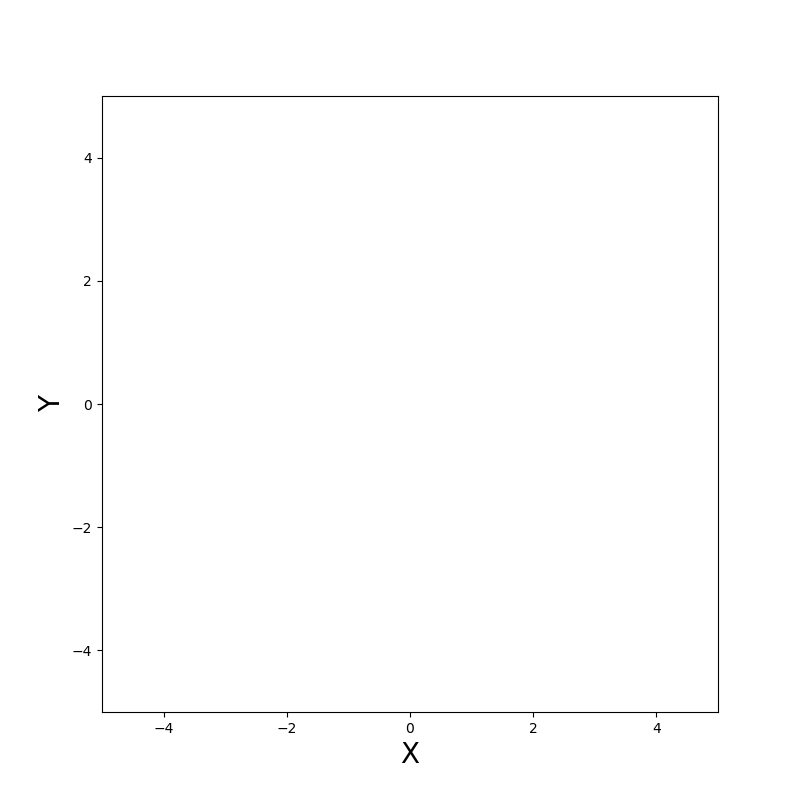

[(array([4.20397347, 0.92676439]), 2)]
[(array([ 3.60932498, -0.91026446]), 1)]
[(array([ 3.56190929, -0.88868423]), 1), (array([4.24592091, 0.90901018]), 2)]
[(array([4.05793291, 0.90646552]), 2)]
[(array([4.22786584, 0.79822636]), 2)]
[(array([4.17743125, 0.78599091]), 2)]
[(array([4.03631736, 0.85065107]), 2)]
[(array([4.19420739, 0.76047456]), 2)]
[(array([4.2284064 , 0.80896459]), 2)]
[(array([4.05467764, 0.74766162]), 2)]
[(array([4.12804686, 0.76791537]), 2)]
[(array([4.0233852 , 0.81703479]), 2)]
[]
[(array([3.99511374, 0.76436395]), 2)]
[(array([4.05610063, 0.75769951]), 2)]
[(array([4.08958608, 0.70064495]), 2)]
[(array([4.00441115, 0.68962391]), 2)]
[(array([4.00513498, 0.70222175]), 2)]
[(array([3.86689163, 0.69763557]), 2)]
[(array([3.98960712, 0.66001263]), 2)]
[(array([4.0382809 , 0.60938777]), 2)]
[(array([3.84582416, 0.61716132]), 2)]
[(array([3.85602928, 0.61996119]), 2)]
[(array([3.76112092, 0.56568543]), 2)]
[(array([3.92135524, 0.5580357 ]), 2)]
[(array([3.95902557

In [5]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)

    m = Map()
    for ln in [(-4, 2), (2, -3), (3, 3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)

    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(initial_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

trial()